In [1]:
import os

base_dir = '/kaggle/input/handwriting-recognition'
train_images_dir = os.path.join(base_dir, 'train_v2/train')
validation_images_dir = os.path.join(base_dir, 'validation_v2/validation')
test_images_dir = os.path.join(base_dir, 'test_v2/test')

# Importnig Importnant Packages


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from sklearn.metrics import classification_report

In [3]:
train_csv = pd.read_csv(os.path.join(base_dir, 'written_name_train_v2.csv'))
validation_csv = pd.read_csv(os.path.join(base_dir, 'written_name_validation_v2.csv'))
test_csv = pd.read_csv(os.path.join(base_dir, 'written_name_test_v2.csv'))

# Clean Data

In [4]:
train_csv.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [5]:
train_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330961 entries, 0 to 330960
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   FILENAME  330961 non-null  object
 1   IDENTITY  330396 non-null  object
dtypes: object(2)
memory usage: 5.1+ MB


In [6]:
# There are 565 null samples
print("Number of null values in train_csv: \n",train_csv.isnull().sum())
print('\n---------------\n')
print("Number of null values in validation_csv: \n",validation_csv.isnull().sum())
print('\n---------------\n')
print("Number of null values in test_csv: \n",test_csv.isnull().sum())

Number of null values in train_csv: 
 FILENAME      0
IDENTITY    565
dtype: int64

---------------

Number of null values in validation_csv: 
 FILENAME     0
IDENTITY    78
dtype: int64

---------------

Number of null values in test_csv: 
 FILENAME     0
IDENTITY    70
dtype: int64


In [7]:
# Drop null samples
train_csv = train_csv.dropna()
validation_csv = validation_csv.dropna()
test_csv = test_csv.dropna()

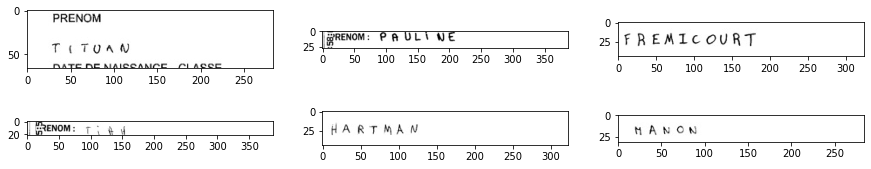

In [8]:
# Plot unreadable image samples from train data
unreadable_indexes = train_csv[train_csv['IDENTITY'] == 'UNREADABLE'].index

plt.figure(figsize = (15,3))

offset = 10
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    image_name = train_csv.iloc[unreadable_indexes[i + offset],0]
    image = cv2.imread(os.path.join(train_images_dir, image_name), cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, 'gray')

In [9]:
train_csv = train_csv[train_csv['IDENTITY'] != 'UNREADABLE']

validation_csv = validation_csv[validation_csv['IDENTITY'] != 'UNREADABLE']

test_csv = test_csv[test_csv['IDENTITY'] != 'UNREADABLE']

In [10]:
# Make all chars lowercase
train_csv['IDENTITY'] = train_csv['IDENTITY'].str.lower()
validation_csv['IDENTITY'] = validation_csv['IDENTITY'].str.lower()
test_csv['IDENTITY'] = test_csv['IDENTITY'].str.lower()



characters = set(char for label in train_csv['IDENTITY'].values for char in label)

print("Number of samples found: ", len(train_csv.values))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of samples found:  330294
Number of unique characters:  30
Characters present:  {'r', 'f', 'l', 't', 'u', 's', 'e', 'y', 'v', 'w', 'b', 'q', ' ', 'm', 'n', 'x', 'g', '-', 'a', 'i', 'o', 'k', 'c', 'p', 'j', 'h', '`', 'z', "'", 'd'}


# Preprocessing

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = max([len(label) for label in train_csv['IDENTITY'].values])
tokenizer = Tokenizer(num_words = max_length, char_level = True)
tokenizer.fit_on_texts(train_csv['IDENTITY'].values)
word_index = tokenizer.word_index

# Tokenize the entire training dataset
train_sequences = tokenizer.texts_to_sequences(train_csv['IDENTITY'].values)

# Select one sample (e.g., the first sample)
sample_index = 5  # Change this index to select a different sample
sample_sequence = train_sequences[sample_index]

# Convert the tokenized sequence back to text
sample_text = tokenizer.sequences_to_texts([sample_sequence])

# Print the result
print("Sample sequence: ", sample_sequence)
print("Sample text: ", sample_text[0])

img_width = 50
img_height = 200

Sample sequence:  [5, 9, 12, 3, 1]
Sample text:  l u c i e


## Preprocess Images

In [12]:
images = train_csv['FILENAME'].values
labels = train_csv['IDENTITY'].values


def preprocess_single_sample(image_path, label, TEST = False):
    if TEST:
        img = cv2.imread(os.path.join(validation_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
    else:
        img = cv2.imread(os.path.join(train_images_dir, image_path), cv2.IMREAD_GRAYSCALE)
        
    img = cv2.resize(img,(img_height, img_width), interpolation = cv2.INTER_AREA)
    img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE) / 255 # normalize the pixels of images to not bias the data into some images
    
    label_sequence = tokenizer.texts_to_sequences([label])
    label = pad_sequences(label_sequence, maxlen = max_length, padding = 'post')[0]
    
    return img,label

In [13]:
train_length = 50000
validation_length = 5000
test_length = 5000

indices = np.arange(len(train_csv))
np.random.shuffle(indices)

test_indices = np.arange(len(test_csv))
np.random.shuffle(test_indices)

In [14]:
x_train = []
y_train = []
train_label_len = []
for i in range(train_length): 
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    train_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_train.append(img)
    y_train.append(label)
    
x_train = np.array(x_train)
y_train = np.array(y_train)
train_label_len = np.array(train_label_len)

In [15]:
x_train
y_train

array([[21,  9,  5, ...,  0,  0,  0],
       [ 6,  3, 10, ...,  0,  0,  0],
       [22,  1,  5, ...,  0,  0,  0],
       ...,
       [ 1,  5,  7, ...,  0,  0,  0],
       [ 4,  9,  6, ...,  0,  0,  0],
       [18,  3,  4, ...,  0,  0,  0]], dtype=int32)

In [16]:
x_val = []
y_val = []
valid_label_len = []

for i in range(train_length, train_length+validation_length):
    image_name = train_csv.iloc[indices[i], 0]
    label = train_csv.iloc[indices[i], 1]
    valid_label_len.append(len(label))
    
    img, label = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_val.append(img)
    y_val.append(label)

x_val = np.array(x_val)
y_val = np.array(y_val)
valid_label_len = np.array(valid_label_len)

In [17]:
x_test = []
y_test = []

for i in range(test_length):
    image_name = train_csv.iloc[test_indices[i], 0]
    label = train_csv.iloc[test_indices[i], 1]
    
    img, _ = preprocess_single_sample(image_name, label)
    img = np.expand_dims(img, axis = 2)
    x_test.append(img)
    y_test.append(label)

x_test = np.array(x_test)
y_test = np.array(y_test)

In [18]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((50000, 200, 50, 1), (5000, 200, 50, 1), (50000, 34), (5000, 34))

In [19]:
train_input_len = np.ones([train_length, 1]) * 48
valid_input_len = np.ones([validation_length, 1]) * 48
valid_output = np.zeros([validation_length])

In [20]:
class CTCLayer(layers.Layer):
    def __init__(self,name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0] , dtype = 'int64')
        input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
        label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')

        input_length = input_length * tf.ones(shape=(batch_len,1), dtype = 'int64')
        label_length = label_length * tf.ones(shape=(batch_len,1), dtype='int64')
        loss = self.loss_fn(y_true,y_pred,input_length,label_length)
        self.add_loss(loss)
        return y_pred
     


In [21]:
from keras import backend as K
def ctc_loss(args):
    labels, y_pred, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


In [25]:
def build_model():
# Inputs to the model
    input_img = layers.Input(shape=(img_height,img_width, 1), name="image")
    labels = layers.Input(name="label", shape=(max_length,))
    input_length = layers.Input(name='input_length', shape=(1,))
    label_length = layers.Input(name='label_length', shape=(1,))

    x = layers.Conv2D(
       32,
       (3, 3),
       activation="relu",
       kernel_initializer="he_normal",
       padding="same",
      name="Conv1",
     )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)


    x = layers.Conv2D(
    64,
    (3, 3),
    activation="relu",
    kernel_initializer="he_normal",
    padding="same",
    name="Conv2",
      )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

#x = layers.Reshape(target_shape=(50,768), name="reshape")(x)
    x = layers.Reshape(target_shape=(img_height//4,(img_width//4 )* 64), name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

#RNN
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(x)

# Output layer
    y_pred = layers.Dense(
          len(characters) + 1, activation="softmax", name="output")(x)

    loss_out = layers.Lambda(ctc_loss, output_shape=(1,), name='ctc')([labels, y_pred, input_length, label_length])


    # Define the model
    model = keras.models.Model(inputs=[input_img, labels, input_length, label_length], 
                           outputs=loss_out,
                           name="ocr_model_v1")
    opt = keras.optimizers.Adam()

    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=opt)
    return model

In [26]:
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 32)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 64)  18496       pool1[0][0]                      
_______________________________________________________________________________________

In [27]:
epochs = 50
early_stopping_patience = 10
# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)T

# rain the model
history = model.fit(
    x = (x_train, y_train, train_input_len, train_label_len),
    y = np.zeros([train_length]),
    validation_data = ([x_val, y_val, valid_input_len, valid_label_len], np.zeros([validation_length]) ),
    epochs=epochs,
    batch_size = 128,
    callbacks=[early_stopping]
)

Epoch 1/50
391/391 [==============================] - 79s 150ms/step - loss: 20.7763 - val_loss: 19.4125
Epoch 2/50
391/391 [==============================] - 55s 141ms/step - loss: 18.7033 - val_loss: 17.0007
Epoch 3/50
391/391 [==============================] - 56s 144ms/step - loss: 14.6732 - val_loss: 10.6615
Epoch 4/50
391/391 [==============================] - 57s 145ms/step - loss: 8.6272 - val_loss: 5.3801
Epoch 5/50
391/391 [==============================] - 57s 145ms/step - loss: 5.7235 - val_loss: 4.1717
Epoch 6/50
391/391 [==============================] - 56s 143ms/step - loss: 4.6186 - val_loss: 3.4023
Epoch 7/50
391/391 [==============================] - 56s 144ms/step - loss: 3.9572 - val_loss: 3.0328
Epoch 8/50
391/391 [==============================] - 56s 144ms/step - loss: 3.4885 - val_loss: 2.7577
Epoch 9/50
391/391 [==============================] - 56s 144ms/step - loss: 3.1326 - val_loss: 2.5687
Epoch 10/50
391/391 [==============================] - 56s 142ms/st

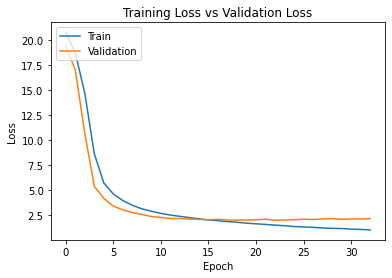

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Prediction Model

In [29]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="output").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 32)       320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 32)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 64)       18496     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 64)        0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 768)           0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 64)            49216 

# Decoding of the prediction

In [30]:
def decode_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    output_text = []
    for res in results:
        decoded = tokenizer.sequences_to_texts([res.numpy()])
        output_text.append(decoded)
    return output_text

In [31]:
preds = prediction_model.predict(x_test)
pred_texts = decode_predictions(preds)

In [32]:
correct = 0
correct_char = 0total_char = 0
test_length = len(pred_texts)

for i in range(test_length):
    pr = pred_texts[i][0].replace(' ', '')  # Extract the predicted word from the list
    tr = y_test[i]
    total_char += len(tr)
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
    if pr == tr:
        correct += 1

accuracy = (correct / test_length) * 100

print(f'Correct words predicted: {accuracy:.2f}%')

Correct words predicted: 72.80%


In [33]:
for i in range(test_length):
    pred_texts[i][0] = pred_texts[i][0].replace(' ', '')

In [35]:
from sklearn.metrics import precision_score, recall_score, f1_score


precision = precision_score(y_test, pred_texts, average='weighted')
recall = recall_score(y_test, pred_texts, average='weighted')
f1 = f1_score(y_test, pred_texts, average='weighted')

print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1-Score: {f1:.2f}')


Precision: 0.75
Recall: 0.73
F1-Score: 0.73


# Some Prediction on test set

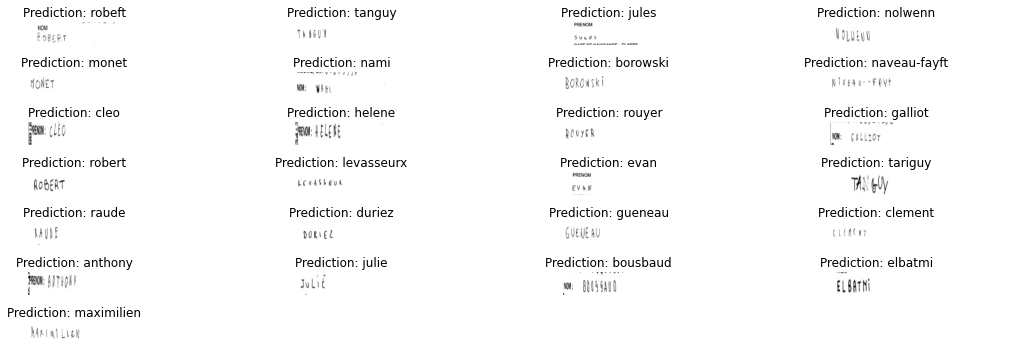

In [36]:
num_images = 25
num_rows = int(np.ceil(num_images / 4))
num_cols = 4

fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 5))

for i in range(num_images):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // num_cols, i % num_cols].imshow(img, cmap="gray")
    ax[i // num_cols, i % num_cols].set_title(title)
    ax[i // num_cols, i % num_cols].axis("off")

# Hide any empty subplots
for i in range(num_images, num_rows * num_cols):
    ax[i // num_cols, i % num_cols].axis("off")

plt.tight_layout()
plt.show()


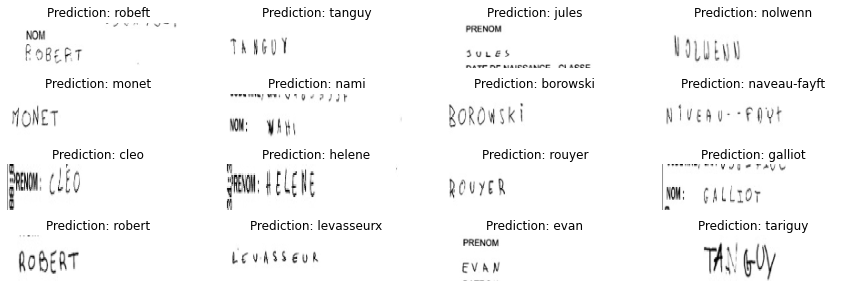

In [38]:
_, ax = plt.subplots(4, 4, figsize=(15, 5))
for i in range(16):
    img = x_test[i]
    img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
    title = f"Prediction: {pred_texts[i][0]}"
    ax[i // 4, i % 4].imshow(img, cmap="gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()